# Download the dataset

In [1]:
!mkdir /tmp/data/ -p
!gdown --id '18WeCp7OPGulOgMl-KN6DN1CJw47IlTQ2' --output /tmp/data/lte.train.csv
!gdown --id '18_nW3nufgDzFFmpuPAWyKUbO11gLU8Ud' --output /tmp/data/lte.test.csv
!git clone https://github.com/lirits/NetworkTrafficPrediction.git

Downloading...
From: https://drive.google.com/uc?id=18WeCp7OPGulOgMl-KN6DN1CJw47IlTQ2
To: /tmp/data/lte.train.csv
100% 20.0M/20.0M [00:00<00:00, 48.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=18_nW3nufgDzFFmpuPAWyKUbO11gLU8Ud
To: /tmp/data/lte.test.csv
100% 396k/396k [00:00<00:00, 57.2MB/s]
Cloning into 'NetworkTrafficPrediction'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 81 (delta 39), reused 60 (delta 21), pack-reused 0
Unpacking objects: 100% (81/81), done.


In [2]:
import sys
if not 'NetworkTrafficPrediction' in sys.path:
    sys.path += ['NetworkTrafficPrediction']

In [3]:
import torch
import matplotlib.pyplot as plt
from data.custom_dataset import LteTrafficDataset
from torch.utils.data import DataLoader

# Dataset&Dataloader

In [19]:
train_file_path = '/tmp/data/lte.train.csv'
test_file_path = '/tmp/data/lte.test.csv'
CellName = 'Cell_003781'
batch_size = 128
windows_size = 128
target_size = 48
transform,target_transform = True,True
learning_rate = 1e-4
epochs=100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
training_data = LteTrafficDataset(train_file_path,CellName=CellName,windows_size=windows_size,target_size=target_size,transform=transform,target_transform=target_transform)
train_dataloader = DataLoader(training_data,batch_size=batch_size,shuffle=True,drop_last=True)
test_data = LteTrafficDataset(test_file_path,CellName,windows_size,target_size,transform,target_transform)
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=False,drop_last=True)

In [21]:
example_x,example_y = next(iter(train_dataloader))
print(example_x.shape,example_y.shape)

torch.Size([128, 128, 1]) torch.Size([128, 48, 1])


#Define the network

In [16]:
from model.Transformer import Transformer

In [23]:
input_dim = 1
output_dim = 24 # input_size of decoder
embed_dim = 1024 # ValueEmbedding
nhead = 8
dim_hid = 1024 #the dimension of the feedforward network model
num_encoder = 2
num_decoder = 1 
dropout = 0.05
pred_size = target_size

In [24]:
net = Transformer(input_dim,output_dim,embed_dim,nhead,dim_hid,num_encoder,num_decoder,dropout,pred_size).to(device)
print(net)

Transformer(
  (encoder_embedding): ValueEmbedding(
    (embedding): Linear(in_features=1, out_features=1024, bias=True)
  )
  (decoder_embedding): ValueEmbedding(
    (embedding): Linear(in_features=1, out_features=1024, bias=True)
  )
  (pos_embedding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (Encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.05, inplace=False)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.05, inplace=False)
        (dropout2): Dropout(p=0.05

In [25]:
pred_y = net(example_x.to(device))
print(example_x.shape,example_y.shape,pred_y.shape)

torch.Size([128, 128, 1]) torch.Size([128, 48, 1]) torch.Size([128, 48, 1])


# Train model

In [26]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)

In [27]:
def train_loop(datalodaer,model,loss_fn,optimizer):
  size = len(datalodaer.dataset)
  for batch,(X,y) in enumerate(datalodaer):
    X,y = X.to(device),y.to(device)
    # compute prediction and loss
    pred = model(X)
    loss = loss_fn(pred,y)
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch %100 ==0 :
      loss,current = loss.item(),batch *len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader,model,loss_fn):
  size = len(dataloader.dataset)
  num_batch = len(dataloader)
  print(num_batch)
  test_loss = 0
  # accuracy = 0


  with torch.no_grad():
    for X,y in dataloader:
      X,y = X.to(device),y.to(device)
      pred = model(X)
      # print(pred.shape,y.shape)
      test_loss += loss_fn(pred,y).item()
      # accuracy += blur_accuracy(pred,y,0.1)

  test_loss /= num_batch
  # accuracy /= num_batch

  print(f"Test Error: \n  Avg Mae loss: {test_loss:>8f} \n")


In [28]:
for t in range(epochs):
  print(f'Epoch {t+1}\n-------------------------------------')
  train_loop(train_dataloader,net,loss_fn,optimizer)
  # test_loop(test_dataloader,net,loss_fn=torch.nn.L1Loss())

Epoch 1
-------------------------------------
loss: 0.312500  [    0/ 8558]
Epoch 2
-------------------------------------
loss: 0.024877  [    0/ 8558]
Epoch 3
-------------------------------------
loss: 0.022640  [    0/ 8558]
Epoch 4
-------------------------------------
loss: 0.020139  [    0/ 8558]
Epoch 5
-------------------------------------
loss: 0.018775  [    0/ 8558]
Epoch 6
-------------------------------------
loss: 0.017561  [    0/ 8558]
Epoch 7
-------------------------------------
loss: 0.017234  [    0/ 8558]
Epoch 8
-------------------------------------
loss: 0.016537  [    0/ 8558]
Epoch 9
-------------------------------------
loss: 0.016101  [    0/ 8558]
Epoch 10
-------------------------------------
loss: 0.016362  [    0/ 8558]
Epoch 11
-------------------------------------
loss: 0.016255  [    0/ 8558]
Epoch 12
-------------------------------------
loss: 0.015951  [    0/ 8558]
Epoch 13
-------------------------------------
loss: 0.015464  [    0/ 8558]
Epoch 14

In [29]:
!nvidia-smi

Sun Oct 10 12:38:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    37W / 250W |   6153MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Plot the result

In [33]:
y_pred.shape

torch.Size([128, 48, 1])

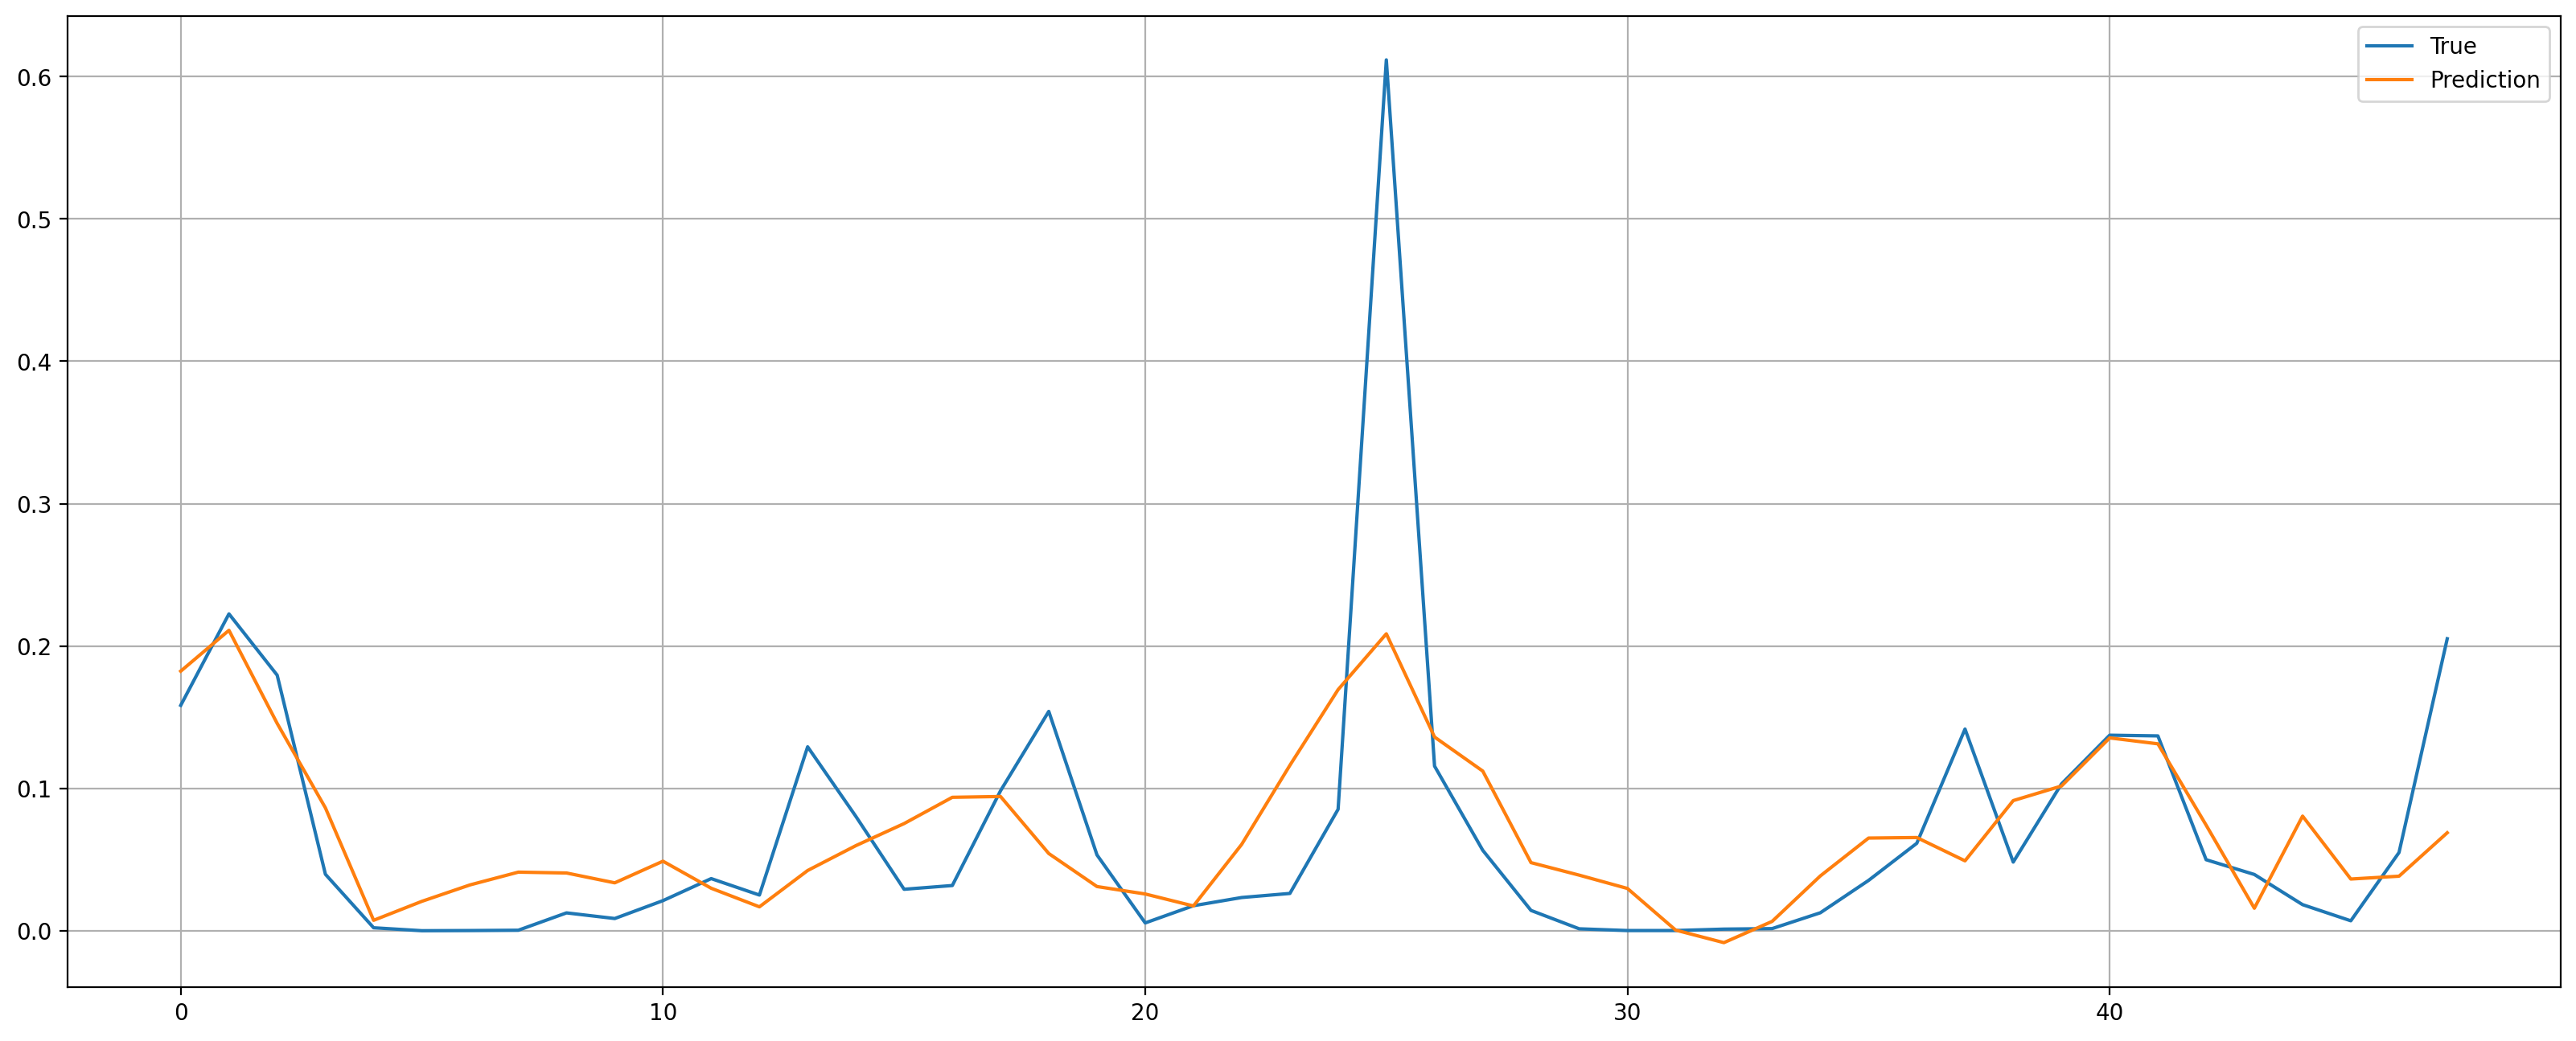

In [67]:
X_train,y_true = next(iter(train_dataloader))
y_pred = net(X_train.to(device))
figure1 = plt.figure(figsize=(20,8),dpi=200)
plt.plot(torch.squeeze(y_true[0,:,0]).to('cpu').detach().numpy(),label='True')
plt.plot(torch.squeeze(y_pred[0,:,0]).to('cpu').detach().numpy(),label='Prediction')
plt.grid()
plt.legend()
plt.show()

In [38]:
y_true = []
y_pred = []
for X,y in train_dataloader:
  for j in y[:,0,0]:
    y_true.append(j.to('cpu'))
  for k in net(X.to(device)).detach().to('cpu')[:,0]:
    y_pred.append(k)

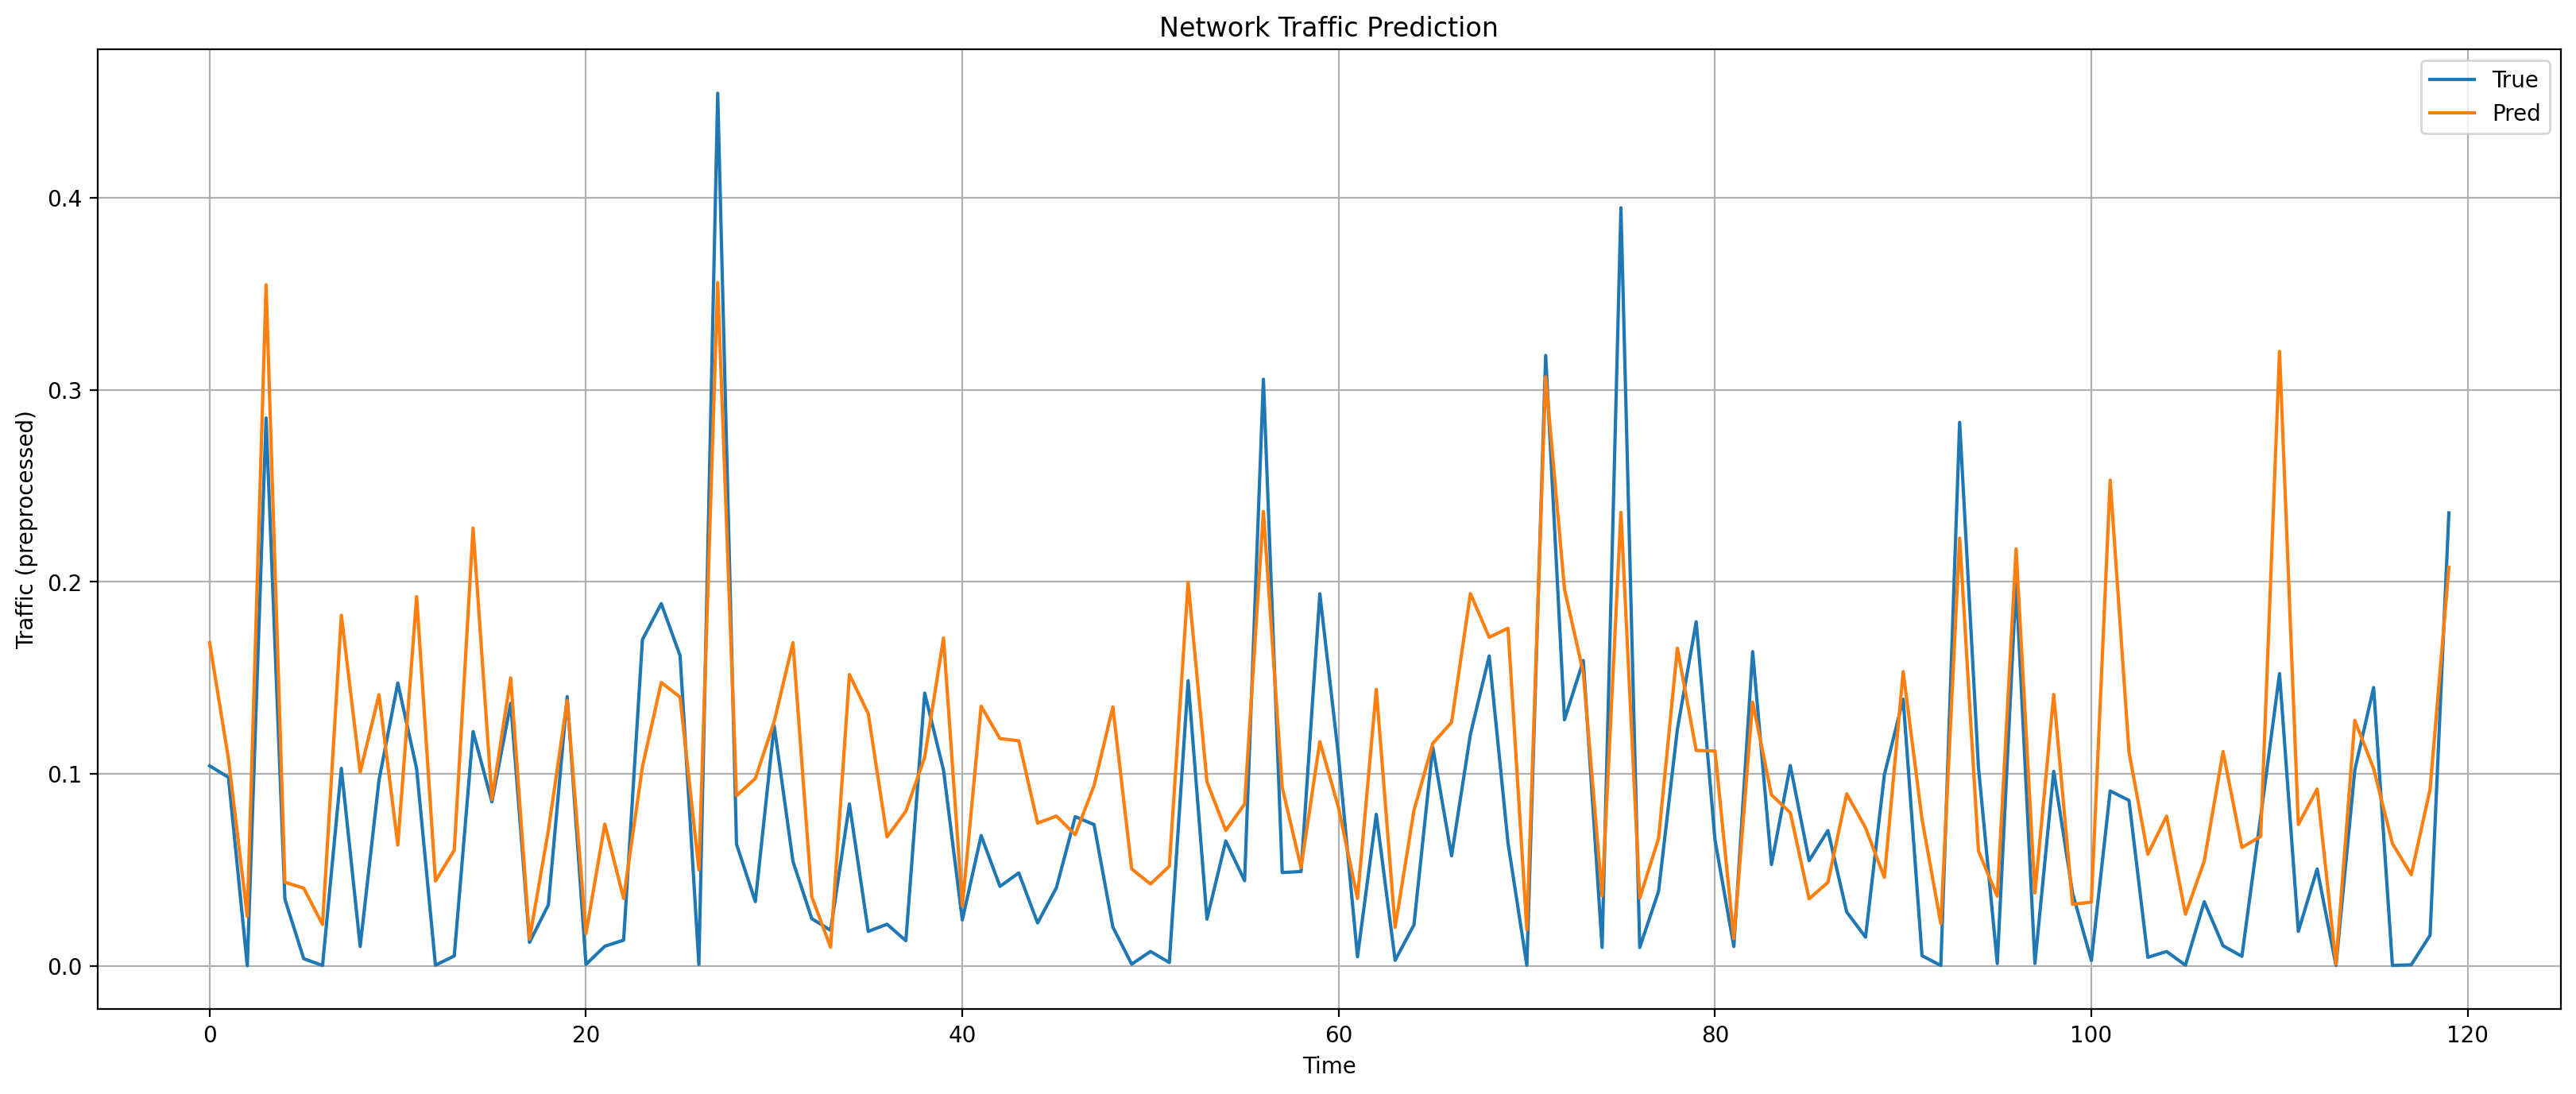

In [40]:
plt.figure(figsize=(20,8),dpi=200)
plt.plot(y_true[:120],label='True')
plt.plot(y_pred[:120],label='Pred')
plt.grid()
plt.legend()
plt.title('Network Traffic Prediction')
plt.xlabel('Time')
plt.ylabel('Traffic (preprocessed)')
plt.show()